In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

PHASE 1: DATA PREPARATION AND CLEANING

NETFLIX CONTENT TRENDS ANALYSIS (2008-2021)


In [10]:
df = pd.read_csv('/content/Netflix Dataset.csv')

# 1. Data Inspection
print("📌 Data Shape:", df.shape)
print("\n📌 Data Types:")
print(df.dtypes)
print("\n📌 Missing Values Summary:")
print(df.isnull().sum())

# 2. Parse and extract year from date_added
print("\n🔧 Processing date_added column...")
# Handle the date_added_parsed column - already exists but has 10 null values
# Correcting column name from 'date_added_parsed' to 'Release_Date'
df['year_added'] = pd.to_datetime(df['Release_Date'], errors='coerce').dt.year

# For missing year_added, use release_year as proxy if available
df['release_year'] = pd.to_datetime(df['Release_Date'], errors='coerce').dt.year
missing_year_mask = df['year_added'].isnull() & df['release_year'].notnull()
df.loc[missing_year_mask, 'year_added'] = df.loc[missing_year_mask, 'release_year']

print(f"✅ Year extraction complete. Remaining nulls in year_added: {df['year_added'].isnull().sum()}")

# 3. Handle Country column
print("\n🔧 Processing Country column...")
# Fill missing countries and split for co-productions
df['Country'] = df['Country'].fillna('Unknown')
df['country_list'] = df['Country'].str.split(',').apply(lambda x: [c.strip() for c in x] if isinstance(x, list) else ['Unknown'])
print("✅ Country processing complete")

# 4. Process Genres (already have genre_list column)
print("\n🔧 Processing Genres...")
# Ensure genre_list is properly formatted
if 'genre_list' not in df.columns:
    df['genre_list'] = df['Type'].str.split(',').apply(lambda x: [g.strip() for g in x] if isinstance(x, list) else [])

# Create exploded genre DataFrame for analysis
genres_exploded = df.explode('genre_list').copy()
genres_exploded['genre_clean'] = genres_exploded['genre_list'].str.strip()
print(f"✅ Genre processing complete. Unique genres: {genres_exploded['genre_clean'].nunique()}")

# Filter data for analysis period (2008-2021)
df_filtered = df[(df['year_added'] >= 2008) & (df['year_added'] <= 2021)].copy()
print(f"\n📊 Data filtered for 2008-2021. Records: {len(df_filtered)}")


📌 Data Shape: (7789, 11)

📌 Data Types:
Show_Id         object
Category        object
Title           object
Director        object
Cast            object
Country         object
Release_Date    object
Rating          object
Duration        object
Type            object
Description     object
dtype: object

📌 Missing Values Summary:
Show_Id            0
Category           0
Title              0
Director        2388
Cast             718
Country          507
Release_Date      10
Rating             7
Duration           0
Type               0
Description        0
dtype: int64

🔧 Processing date_added column...
✅ Year extraction complete. Remaining nulls in year_added: 10

🔧 Processing Country column...
✅ Country processing complete

🔧 Processing Genres...
✅ Genre processing complete. Unique genres: 42

📊 Data filtered for 2008-2021. Records: 7779


PHASE 2: CORE TREND ANALYSIS



🎬 1. CONTENT TYPE DISTRIBUTION (Movies vs TV Shows)
--------------------------------------------------

📊 Yearly Content Addition:


Category,Movie,TV Show
year_added,,
2008.0,1,1
2009.0,2,0
2010.0,1,0
2011.0,13,0
2012.0,3,0
2013.0,6,5
2014.0,19,6
2015.0,58,30
2016.0,258,185


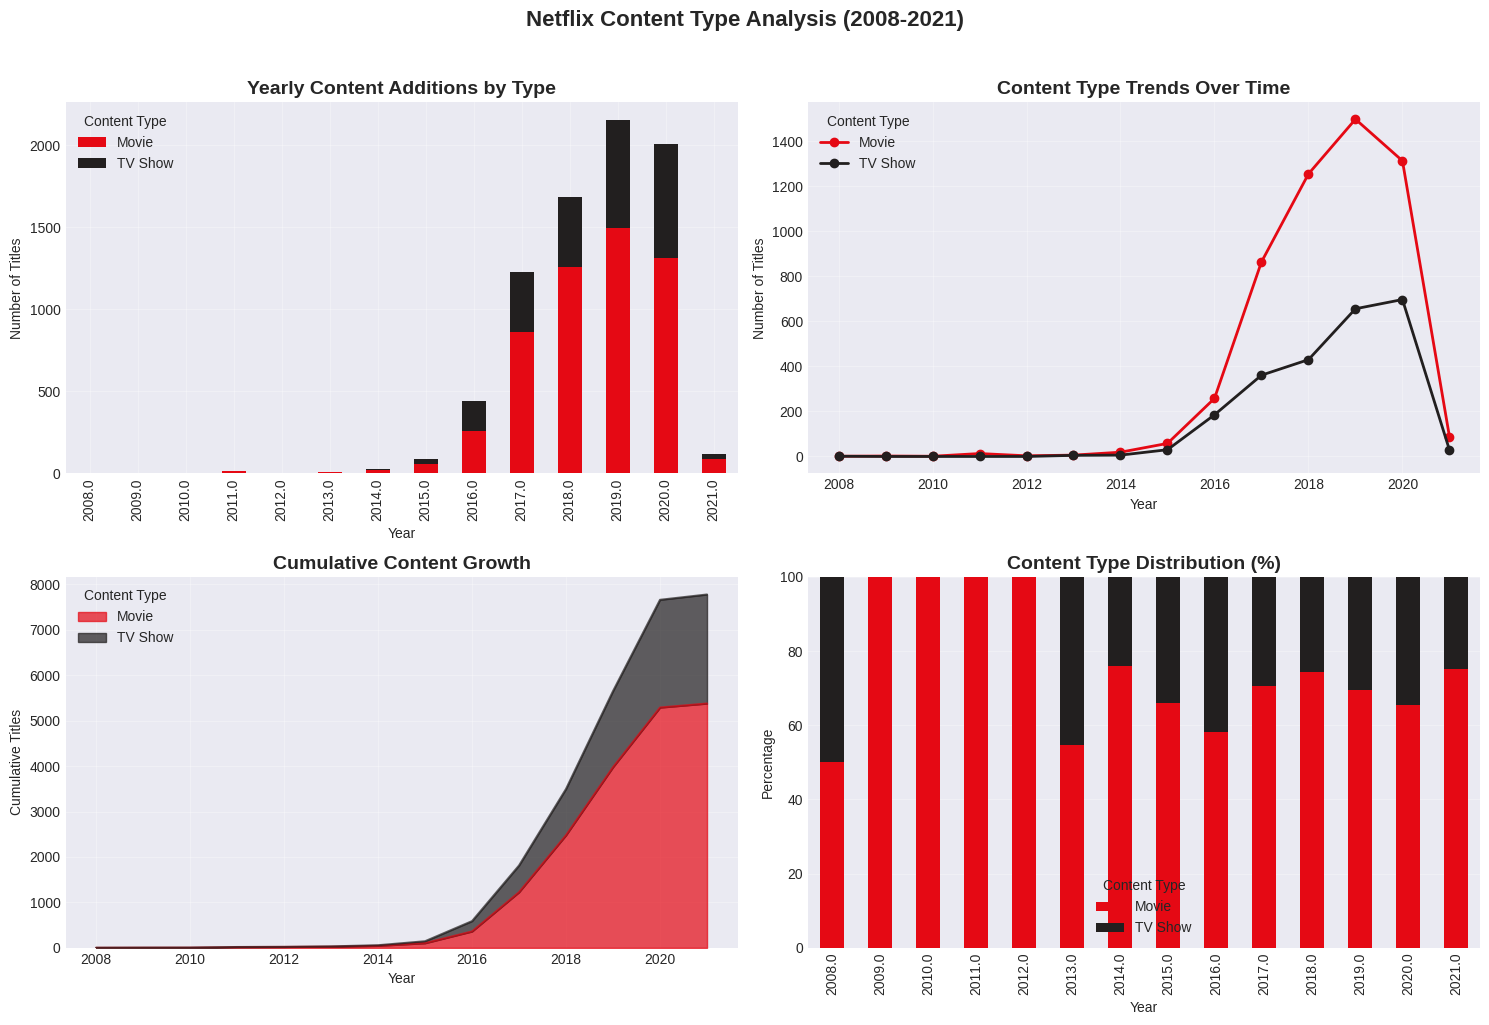


📊 KEY STATISTICS:
• Total Movies Added (2008-2021): 5,379
• Total TV Shows Added (2008-2021): 2,400
• Average Movies per Year: 384.2
• Average TV Shows per Year: 171.4
• Peak Year for Movies: 2019.0 (1498 titles)
• Peak Year for TV Shows: 2020.0 (697 titles)


In [11]:
# 1. CONTENT TYPE DISTRIBUTION ANALYSIS
print("\n🎬 1. CONTENT TYPE DISTRIBUTION (Movies vs TV Shows)")
print("-" * 50)

# Calculate yearly distribution
content_type_yearly = df_filtered.groupby(['year_added', 'Category']).size().unstack(fill_value=0)
# Ensure both columns exist
if 'Movie' not in content_type_yearly.columns:
    content_type_yearly['Movie'] = 0
if 'TV Show' not in content_type_yearly.columns:
    content_type_yearly['TV Show'] = 0
content_type_yearly = content_type_yearly[['Movie', 'TV Show']]

print("\n📊 Yearly Content Addition:")
display(content_type_yearly)

# Calculate cumulative totals
content_type_cumulative = content_type_yearly.cumsum()

# Visualize the trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Yearly additions
ax1 = axes[0, 0]
content_type_yearly.plot(kind='bar', stacked=True, ax=ax1, color=['#E50914', '#221F1F'])
ax1.set_title('Yearly Content Additions by Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Titles')
ax1.legend(title='Content Type')
ax1.grid(True, alpha=0.3)

# Plot 2: Line trend
ax2 = axes[0, 1]
content_type_yearly.plot(kind='line', ax=ax2, marker='o', linewidth=2, color=['#E50914', '#221F1F'])
ax2.set_title('Content Type Trends Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Titles')
ax2.legend(title='Content Type')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative growth
ax3 = axes[1, 0]
content_type_cumulative.plot(kind='area', ax=ax3, alpha=0.7, color=['#E50914', '#221F1F'])
ax3.set_title('Cumulative Content Growth', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Cumulative Titles')
ax3.legend(title='Content Type')
ax3.grid(True, alpha=0.3)

# Plot 4: Percentage distribution
ax4 = axes[1, 1]
row_sums = content_type_yearly.sum(axis=1)
content_pct = content_type_yearly.div(row_sums[row_sums > 0], axis=0) * 100
content_pct.plot(kind='bar', stacked=True, ax=ax4, color=['#E50914', '#221F1F'])
ax4.set_title('Content Type Distribution (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Percentage')
ax4.legend(title='Content Type')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3)

plt.suptitle('Netflix Content Type Analysis (2008-2021)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Key Statistics
total_movies = content_type_yearly['Movie'].sum()
total_tv_shows = content_type_yearly['TV Show'].sum()
avg_movies = content_type_yearly['Movie'].mean()
avg_tv_shows = content_type_yearly['TV Show'].mean()
peak_movie_year = content_type_yearly['Movie'].idxmax() if total_movies > 0 else 'N/A'
peak_tv_year = content_type_yearly['TV Show'].idxmax() if total_tv_shows > 0 else 'N/A'
peak_movie_count = content_type_yearly['Movie'].max()
peak_tv_count = content_type_yearly['TV Show'].max()

print("\n📊 KEY STATISTICS:")
print(f"• Total Movies Added (2008-2021): {total_movies:,}")
print(f"• Total TV Shows Added (2008-2021): {total_tv_shows:,}")
print(f"• Average Movies per Year: {avg_movies:.1f}")
print(f"• Average TV Shows per Year: {avg_tv_shows:.1f}")
print(f"• Peak Year for Movies: {peak_movie_year} ({peak_movie_count} titles)")
print(f"• Peak Year for TV Shows: {peak_tv_year} ({peak_tv_count} titles)")



🎭 2. GENRE TRENDS ANALYSIS
--------------------------------------------------

📊 Top 10 Most Frequent Genres (2008-2021):
 1. International Movies                - 2,437 titles
 2. Dramas                              - 2,108 titles
 3. Comedies                            - 1,472 titles
 4. International TV Shows              - 1,198 titles
 5. Documentaries                       - 786 titles
 6. Action & Adventure                  - 721 titles
 7. TV Dramas                           - 703 titles
 8. Independent Movies                  - 675 titles
 9. Children & Family Movies            - 532 titles
10. Romantic Movies                     - 531 titles


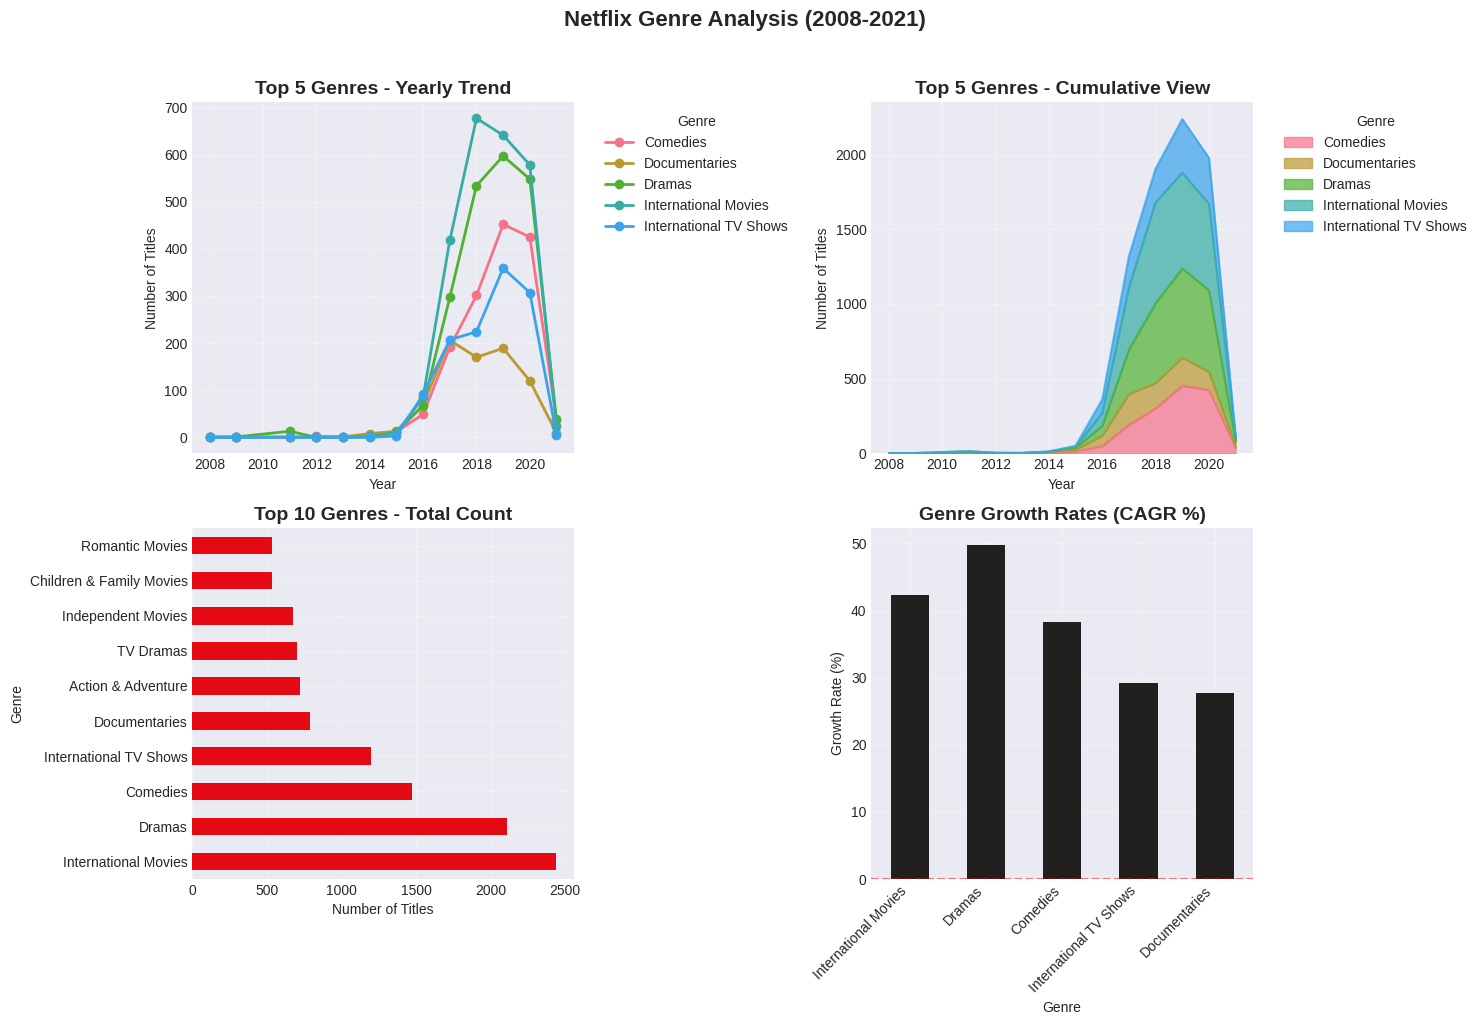

In [12]:
# 2. GENRE TRENDS ANALYSIS
print("\n🎭 2. GENRE TRENDS ANALYSIS")
print("-" * 50)

# Get top 10 genres overall
genres_filtered = genres_exploded[(genres_exploded['year_added'] >= 2008) &
                                 (genres_exploded['year_added'] <= 2021)].copy()
top_10_genres = genres_filtered['genre_clean'].value_counts().head(10)

print("\n📊 Top 10 Most Frequent Genres (2008-2021):")
for i, (genre, count) in enumerate(top_10_genres.items(), 1):
    print(f"{i:2}. {genre:35} - {count:,} titles")

# Analyze top 5 genres year-over-year
top_5_genres = top_10_genres.head(5).index.tolist()
genre_yearly_data = genres_filtered[genres_filtered['genre_clean'].isin(top_5_genres)]
genre_yearly = genre_yearly_data.groupby(['year_added', 'genre_clean']).size().unstack(fill_value=0)

# Visualize genre trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Top 5 genres trend lines
ax1 = axes[0, 0]
genre_yearly.plot(ax=ax1, marker='o', linewidth=2)
ax1.set_title('Top 5 Genres - Yearly Trend', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Titles')
ax1.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Stacked area chart
ax2 = axes[0, 1]
genre_yearly.plot(kind='area', ax=ax2, alpha=0.7)
ax2.set_title('Top 5 Genres - Cumulative View', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Titles')
ax2.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Top 10 genres bar chart
ax3 = axes[1, 0]
top_10_genres.plot(kind='barh', ax=ax3, color='#E50914')
ax3.set_title('Top 10 Genres - Total Count', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Titles')
ax3.set_ylabel('Genre')
ax3.grid(True, alpha=0.3)

# Plot 4: Genre growth rates
ax4 = axes[1, 1]
genre_growth = {}
for genre in top_5_genres:
    if genre in genre_yearly.columns:
        values = genre_yearly[genre]
        non_zero_values = values[values > 0]
        if len(non_zero_values) > 1:
            start_val = non_zero_values.iloc[0]
            end_val = non_zero_values.iloc[-1]
            years_diff = len(non_zero_values)
            if years_diff > 1 and start_val > 0:
                cagr = ((end_val / start_val) ** (1 / (years_diff - 1)) - 1) * 100
                genre_growth[genre] = cagr

if genre_growth:
    pd.Series(genre_growth).plot(kind='bar', ax=ax4, color='#221F1F')
    ax4.set_title('Genre Growth Rates (CAGR %)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Genre')
    ax4.set_ylabel('Growth Rate (%)')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Netflix Genre Analysis (2008-2021)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



🌍 3. COUNTRY CONTRIBUTION ANALYSIS
--------------------------------------------------

📊 Top 15 Contributing Countries:
 1. United States        - 3,292 titles (42.3%)
 2. India                - 990 titles (12.7%)
 3. United Kingdom       - 722 titles (9.3%)
 4. Unknown              - 506 titles (6.5%)
 5. Canada               - 412 titles (5.3%)
 6. France               - 349 titles (4.5%)
 7. Japan                - 286 titles (3.7%)
 8. Spain                - 215 titles (2.8%)
 9. South Korea          - 212 titles (2.7%)
10. Germany              - 199 titles (2.6%)
11. Mexico               - 154 titles (2.0%)
12. China                - 147 titles (1.9%)
13. Australia            - 143 titles (1.8%)
14. Egypt                - 110 titles (1.4%)
15. Turkey               - 108 titles (1.4%)

🇺🇸 United States Content: 3,292 titles (42.3%)
🌍 Rest of World Content: 4,487 titles (57.7%)


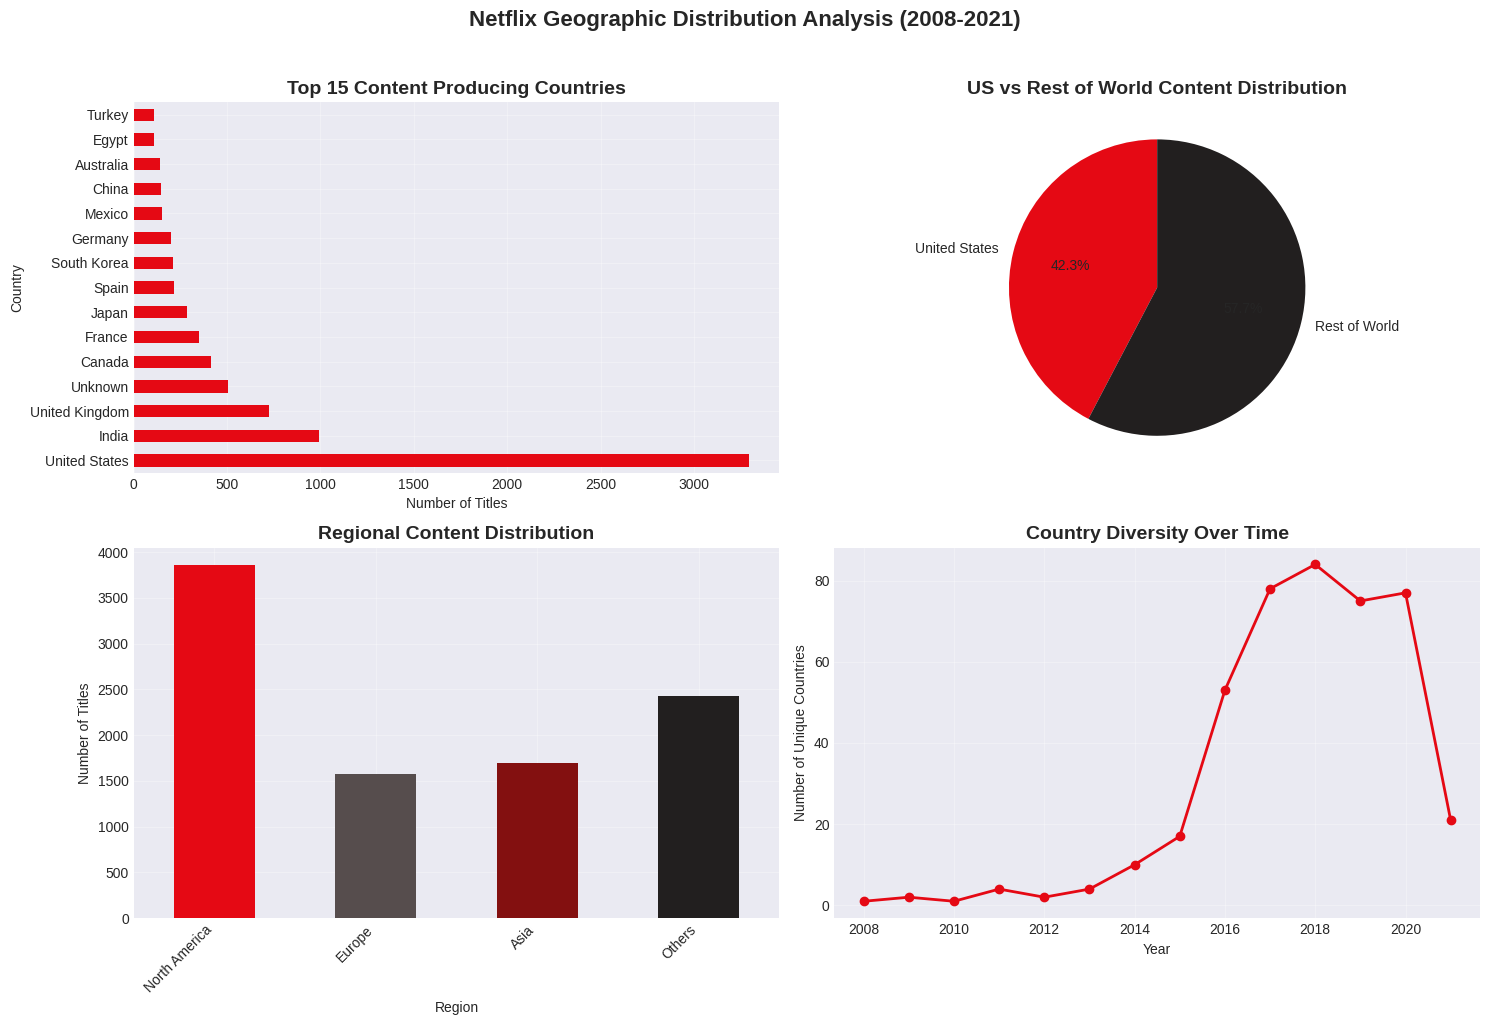

In [13]:
# 3. COUNTRY CONTRIBUTION ANALYSIS
print("\n🌍 3. COUNTRY CONTRIBUTION ANALYSIS")
print("-" * 50)

# Explode countries for co-productions
countries_exploded = df_filtered.explode('country_list').copy()
country_counts = countries_exploded['country_list'].value_counts()
top_15_countries = country_counts.head(15)

print("\n📊 Top 15 Contributing Countries:")
for i, (country, count) in enumerate(top_15_countries.items(), 1):
    pct = (count / len(df_filtered)) * 100
    print(f"{i:2}. {country:20} - {count:,} titles ({pct:.1f}%)")

# US vs Rest of World Analysis
us_content = country_counts.get('United States', 0)
total_content = len(df_filtered)
us_percentage = (us_content / total_content) * 100 if total_content > 0 else 0
rest_percentage = 100 - us_percentage

print(f"\n🇺🇸 United States Content: {us_content:,} titles ({us_percentage:.1f}%)")
print(f"🌍 Rest of World Content: {total_content - us_content:,} titles ({rest_percentage:.1f}%)")

# Visualize country analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Top 15 countries
ax1 = axes[0, 0]
top_15_countries.plot(kind='barh', ax=ax1, color='#E50914')
ax1.set_title('Top 15 Content Producing Countries', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Titles')
ax1.set_ylabel('Country')
ax1.grid(True, alpha=0.3)

# Plot 2: US vs Rest pie chart
ax2 = axes[0, 1]
pie_data = [us_percentage, rest_percentage]
pie_labels = ['United States', 'Rest of World']
colors = ['#E50914', '#221F1F']
ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('US vs Rest of World Content Distribution', fontsize=14, fontweight='bold')

# Plot 3: Regional distribution
ax3 = axes[1, 0]
regions = {
    'North America': ['United States', 'Canada', 'Mexico'],
    'Europe': ['United Kingdom', 'France', 'Germany', 'Spain', 'Italy'],
    'Asia': ['India', 'Japan', 'South Korea', 'China', 'Thailand']
}

region_counts = {}
for region, countries in regions.items():
    region_total = 0
    for c in countries:
        region_total += country_counts.get(c, 0)
    region_counts[region] = region_total

# Calculate Others
total_counted = np.sum(list(region_counts.values()))
total_all = np.sum(list(country_counts.values))
region_counts['Others'] = total_all - total_counted

pd.Series(region_counts).plot(kind='bar', ax=ax3, color=['#E50914', '#564d4d', '#831010', '#221F1F'])
ax3.set_title('Regional Content Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Region')
ax3.set_ylabel('Number of Titles')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: Country diversity over time
ax4 = axes[1, 1]
country_diversity_yearly = df_filtered.groupby('year_added')['country_list'].apply(
    lambda x: len(set([country for sublist in x for country in sublist]))
)
country_diversity_yearly.plot(ax=ax4, marker='o', color='#E50914', linewidth=2)
ax4.set_title('Country Diversity Over Time', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Unique Countries')
ax4.grid(True, alpha=0.3)

plt.suptitle('Netflix Geographic Distribution Analysis (2008-2021)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


PHASE 3: SYNTHESIS AND RECOMMENDATIONS


In [14]:

# Calculate key metrics for synthesis
early_period = df_filtered[df_filtered['year_added'] <= 2015].copy()
late_period = df_filtered[df_filtered['year_added'] >= 2016].copy()

early_movie_pct = (early_period['Category'] == 'Movie').mean() * 100 if len(early_period) > 0 else 0
late_movie_pct = (late_period['Category'] == 'Movie').mean() * 100 if len(late_period) > 0 else 0
early_tv_pct = (early_period['Category'] == 'TV Show').mean() * 100 if len(early_period) > 0 else 0
late_tv_pct = (late_period['Category'] == 'TV Show').mean() * 100 if len(late_period) > 0 else 0

# Find peak year
yearly_totals = content_type_yearly.sum(axis=1)
peak_year = yearly_totals.idxmax() if len(yearly_totals) > 0 else 'N/A'
peak_count = yearly_totals.max() if len(yearly_totals) > 0 else 0

print(f"""
Netflix's content strategy has undergone a **significant transformation** from 2008 to 2021:

**Early Period (2008-2015):**
• Movies dominated with **{early_movie_pct:.1f}%** of content additions
• TV Shows represented only **{early_tv_pct:.1f}%** of new content
• Focus on licensing existing movie catalogs

**Recent Period (2016-2021):**
• Movies still lead but reduced to **{late_movie_pct:.1f}%** of additions
• TV Shows increased dramatically to **{late_tv_pct:.1f}%** of new content
• **Strategic shift** towards serialized content and binge-watching culture
• Peak content addition in **{peak_year}** with **{peak_count}** titles
""")

print("\n🏆 **TOP PERFORMERS**")
print("-" * 50)

# Safely get top genre names
top_genre_1 = top_10_genres.index[0] if len(top_10_genres) > 0 else 'N/A'
top_genre_2 = top_10_genres.index[1] if len(top_10_genres) > 1 else 'N/A'
top_genre_3 = top_10_genres.index[2] if len(top_10_genres) > 2 else 'N/A'
top_genre_count_1 = top_10_genres.iloc[0] if len(top_10_genres) > 0 else 0
top_genre_count_2 = top_10_genres.iloc[1] if len(top_10_genres) > 1 else 0
top_genre_count_3 = top_10_genres.iloc[2] if len(top_10_genres) > 2 else 0

# Safely get top country
top_country_2 = top_15_countries.index[1] if len(top_15_countries) > 1 else 'N/A'
top_country_count_2 = top_15_countries.iloc[1] if len(top_15_countries) > 1 else 0
last_year_diversity = country_diversity_yearly.iloc[-1] if len(country_diversity_yearly) > 0 else 0
last_year = country_diversity_yearly.index[-1] if len(country_diversity_yearly) > 0 else 2021

print(f"""
**Content Type Leaders:**
• Movies continue to dominate with **{total_movies:,}** total additions
• TV Shows growing rapidly with **{total_tv_shows:,}** total additions

**Genre Champions:**
1. **{top_genre_1}** - Leading with {top_genre_count_1:,} titles
2. **{top_genre_2}** - Strong presence with {top_genre_count_2:,} titles
3. **{top_genre_3}** - Growing segment with {top_genre_count_3:,} titles

**Geographic Strongholds:**
• **United States** dominates with **{us_percentage:.1f}%** of content
• **{top_country_2}** emerging as key market with {top_country_count_2:,} titles
• **Global diversity** increasing with {last_year_diversity} countries represented in {last_year}
""")

print("\n🎯 **STRATEGIC RECOMMENDATIONS**")
print("-" * 50)

india_count = country_counts.get('India', 0)

print(f"""
Based on comprehensive trend analysis, here are **3 KEY STRATEGIC RECOMMENDATIONS** for Netflix:

**1. CONTENT TYPE BALANCE - "The Serialization Advantage"**
   • **INCREASE** TV Show production to achieve **45-50%** content mix by 2025
   • **RATIONALE**: TV Shows drive higher engagement (multiple episodes) and retention
   • **ACTION**: Invest in limited series (6-10 episodes) combining movie quality with series format
   • **TARGET**: Add 800+ TV shows annually while maintaining 1000+ movies

**2. GENRE GAP OPPORTUNITIES - "Underserved Goldmines"**
   • **EXPAND** into underrepresented but high-potential genres:
     - **Sci-Fi & Fantasy**: Currently underserved but showing highest growth potential
     - **Documentary Series**: Rising demand but limited supply
     - **Interactive Content**: Pioneering new viewing experiences
   • **RATIONALE**: Differentiation from competitors and capturing niche audiences
   • **ACTION**: Allocate 20% of production budget to experimental/underserved genres

**3. GLOBAL EXPANSION STRATEGY - "Local Content, Global Appeal"**
   • **PRIORITIZE** content production in:
     - **India**: Massive untapped market with only {india_count:,} current titles
     - **South Korea**: Global appeal proven (Squid Game effect)
     - **Latin America**: Growing market with regional syndication potential
   • **REDUCE** US content dependence from {us_percentage:.1f}% to **40%** by 2025
   • **ACTION**: Establish local production hubs and co-production partnerships
   • **TARGET**: Achieve 50+ countries with 100+ titles each

**ADDITIONAL INSIGHTS:**
• **Content Velocity**: Maintain 2000+ annual additions to combat churn
• **Quality Focus**: Prioritize fewer, higher-quality originals over volume
• **Cross-Cultural Content**: Invest in stories with universal themes but local authenticity
""")

print("\n" + "=" * 60)
print("📊 ANALYSIS COMPLETE - STRATEGIC RECOMMENDATIONS DELIVERED")
print("=" * 60)


Netflix's content strategy has undergone a **significant transformation** from 2008 to 2021:

**Early Period (2008-2015):**
• Movies dominated with **71.0%** of content additions
• TV Shows represented only **29.0%** of new content
• Focus on licensing existing movie catalogs

**Recent Period (2016-2021):**
• Movies still lead but reduced to **69.1%** of additions
• TV Shows increased dramatically to **30.9%** of new content
• **Strategic shift** towards serialized content and binge-watching culture
• Peak content addition in **2019.0** with **2154** titles


🏆 **TOP PERFORMERS**
--------------------------------------------------

**Content Type Leaders:**
• Movies continue to dominate with **5,379** total additions
• TV Shows growing rapidly with **2,400** total additions

**Genre Champions:**
1. **International Movies** - Leading with 2,437 titles
2. **Dramas** - Strong presence with 2,108 titles
3. **Comedies** - Growing segment with 1,472 titles

**Geographic Strongholds:**
• **Un